In [1]:
# Importing libraries
from qiskit.providers.aer import AerSimulator
from quake.utils.utils import load_runcard
from pathlib import Path
from quake.models.qsvm.qsvm_tester import get_features, make_kernels, SvmsComparison
from quake.models.qsvm import quantum_featuremaps
from qiskit.circuit import ParameterVector
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit import IBMQ

2022-06-27 01:25:54.430296: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Getting feature distributions from cnn or attention
input_folder = Path('../../output/tmp/')
setup = load_runcard("../../output/tmp/cards/runcard.yaml")
output_folder = Path("Output_QSVM_bo")
dataset, labels = get_features(input_folder, 'cnn', setup)

[INFO] (quake.cnn) Loading../../output/tmp/data/e_4283.root.npz
INFO:quake.cnn:Loading../../output/tmp/data/e_4283.root.npz
[INFO] (quake.cnn) Loading../../output/tmp/data/bb_13659.root.npz
INFO:quake.cnn:Loading../../output/tmp/data/bb_13659.root.npz
[INFO] (quake.cnn) Loading../../output/tmp/data/bb_13746.root.npz
INFO:quake.cnn:Loading../../output/tmp/data/bb_13746.root.npz
[INFO] (quake.cnn) Loading../../output/tmp/data/e_23517.root.npz
INFO:quake.cnn:Loading../../output/tmp/data/e_23517.root.npz
[INFO] (quake.cnn) Loading../../output/tmp/data/bb_11771.root.npz
INFO:quake.cnn:Loading../../output/tmp/data/bb_11771.root.npz
[INFO] (quake.cnn) Loading../../output/tmp/data/e_26190.root.npz
INFO:quake.cnn:Loading../../output/tmp/data/e_26190.root.npz
[INFO] (quake.cnn) Loading../../output/tmp/data/bb_12227.root.npz
INFO:quake.cnn:Loading../../output/tmp/data/bb_12227.root.npz
[INFO] (quake.cnn) Loading../../output/tmp/data/e_25714.root.npz
INFO:quake.cnn:Loading../../output/tmp/data/e_2

27/27 [==============================] - 0s 12ms/step


In [3]:
qubits = dataset[-1].shape[-1]
x = ParameterVector('x', length=qubits)
backend = AerSimulator(method="statevector")

zf = quantum_featuremaps.z_featuremap(x, qubits, 1)
zzf = quantum_featuremaps.zz_featuremap(x, qubits, 1)
c1 = quantum_featuremaps.custom1_featuremap(x, qubits, 1)
c2 = quantum_featuremaps.custom2_featuremap(x, qubits, 1)

quantum_kernels = make_kernels([zf, zzf, c1, c2], backend)

In [4]:
# Hyperparameters of classical SVMs
linear = {"kernel": "linear", "C":1, "gamma":10}
poly = {"kernel": "poly", "C":1, "degree":3}
rbf = {"kernel": "rbf", "C":10, "gamma":1}
opts = [linear, poly, rbf]

In [5]:
# Inputs for the comparer class
settings = {
    'x': x,
    'quantum_featuremaps': [zf, zzf, c1, c2],
    'quantum_kernels': quantum_kernels,
    'kernel_names': ['Z', 'ZZ', 'c1', 'c2'],
    'cs': [1000, 1000, 200, 1000],
    'training_size': [20, 50, 100, 200],
    'val_size': 200,
    'test_size': 200,
    'folder_name': output_folder, 
    'folds': 20,
    'backend': backend,
    "classic_opts": opts,
} 

Plotting the dataset


<Figure size 3600x7200 with 0 Axes>

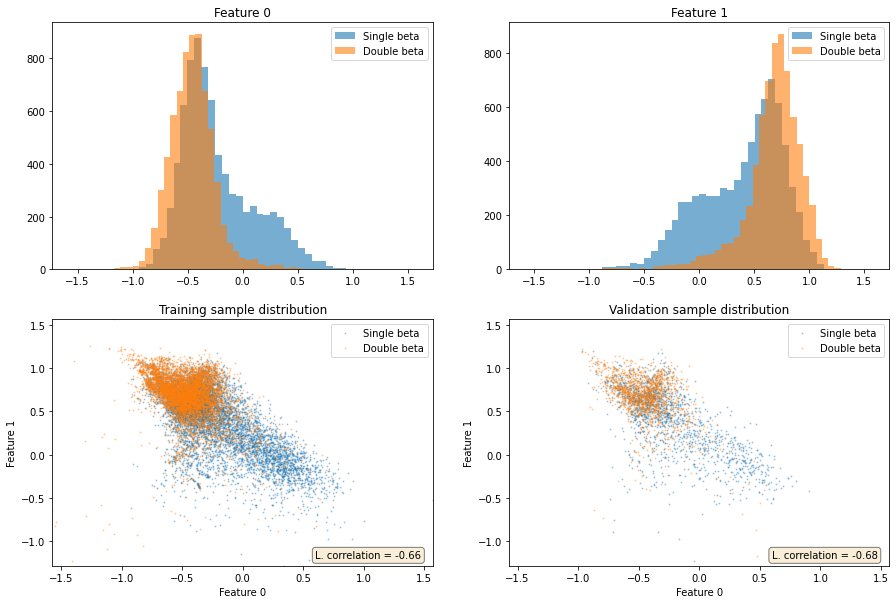

In [6]:
# Initialization
comparer = SvmsComparison(**settings)

# Plotting feature distributions
comparer.plot_data(dataset, labels)

In [7]:
# Training models and getting scores
comparer.train_svms(dataset, labels)

# Plotting the learning curves
comparer.learning_curves()

Starting the training session
Training subset 0 with 20 samples.
Training subset 1 with 20 samples.
Training subset 2 with 20 samples.
Training subset 3 with 20 samples.
Training subset 4 with 20 samples.
Training subset 5 with 20 samples.
Training subset 6 with 20 samples.
Training subset 7 with 20 samples.
Training subset 8 with 20 samples.
Training subset 9 with 20 samples.
Training subset 10 with 20 samples.
Training subset 11 with 20 samples.
Training subset 12 with 20 samples.
Training subset 13 with 20 samples.
Training subset 14 with 20 samples.
Training subset 15 with 20 samples.
Training subset 16 with 20 samples.
Training subset 17 with 20 samples.
Training subset 18 with 20 samples.
Training subset 19 with 20 samples.
Training subset 0 with 50 samples.
Training subset 1 with 50 samples.
Training subset 2 with 50 samples.
Training subset 3 with 50 samples.
Training subset 4 with 50 samples.
Training subset 5 with 50 samples.
Training subset 6 with 50 samples.
Training subset

KeyboardInterrupt: 

In [ ]:
# Saving the decision boundaries in the output folder 
# Set cheap_version to False for better, but time consuming, plots.
comparer.plot_decision_boundaries(cheap_version = False)

Plotting decision boundaries


Plotting Bloch spheres


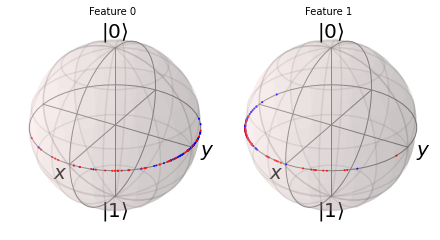

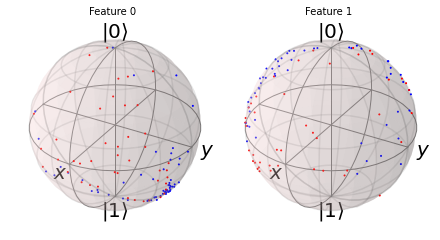

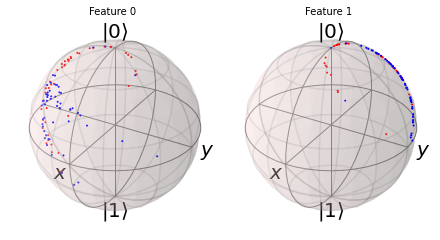

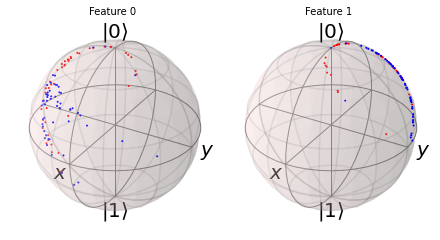

In [ ]:
# Plotting Bloch spheres representation
comparer.plot_bloch_spheres(dataset, labels)

Plotting kernel matrices


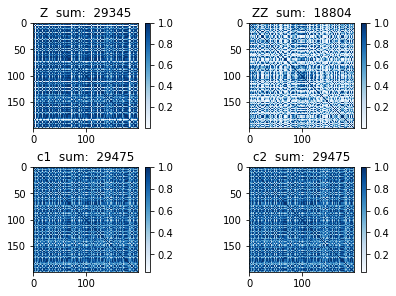

In [ ]:
# Plotting kernel matrices
comparer.plot_kernels()

Doing cross validated trainings


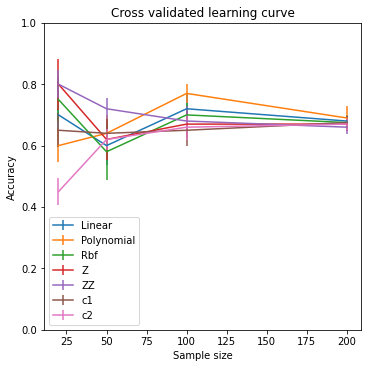

In [ ]:
# Training the svms for computing the cross validated accuracy (only on training set)
comparer.train_svms_cv(dataset, labels)

In [ ]:
# Saving data into the output folder
comparer.save(settings)

Saving data in ../../Output_QSVM


In [ ]:
# Loding data into another class
copy = SvmsComparison(**settings)
copy.load_files(comparer.path)

Loading data from ../../Output_QSVM
